In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from jupyterthemes import jtplot
jtplot.style(theme="grade3")

In [2]:
def cap(x,quantile=[0.01,0.99]):
    """
    CAP Algorithm to delete the outliers
    
    Args：
        x：pd.Series
        quantile：upper/lower boundary in precentage
    """

    Q01,Q99=x.quantile(quantile).values.tolist()

    if Q01 > x.min():
        x = x.copy()
        x.loc[x<Q01] = Q01

    if Q99 < x.max():
        x = x.copy()
        x.loc[x>Q99] = Q99

    return(x)

# Load Data

In [3]:
listener_256 = glob.glob("./q7/256/*.txt")
listener_256K = glob.glob("./q7/256K/*.txt")

data_256 = np.zeros([600, len(listener_256)])
data_256K = np.zeros([600, len(listener_256K)])

for i in range(len(listener_256)):
        data_256[:, i] = np.loadtxt(listener_256[i], dtype=np.float64) * 1000 # convert "s" to "ms"
for i in range(len(listener_256K)):
        data_256K[:, i] = np.loadtxt(listener_256K[i], dtype=np.float64) * 1000 # convert "s" to "ms"   

data_256 = data_256[30:, :] # drop the first 30 outliers
data_256K = data_256K[30:, :] # drop the first 30 outliers

# Make pd.Dataframe

In [4]:
col_name = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

df_256 = pd.DataFrame(data=data_256, columns=col_name)
df_256K = pd.DataFrame(data=data_256K, columns=col_name)

# Box-Plot

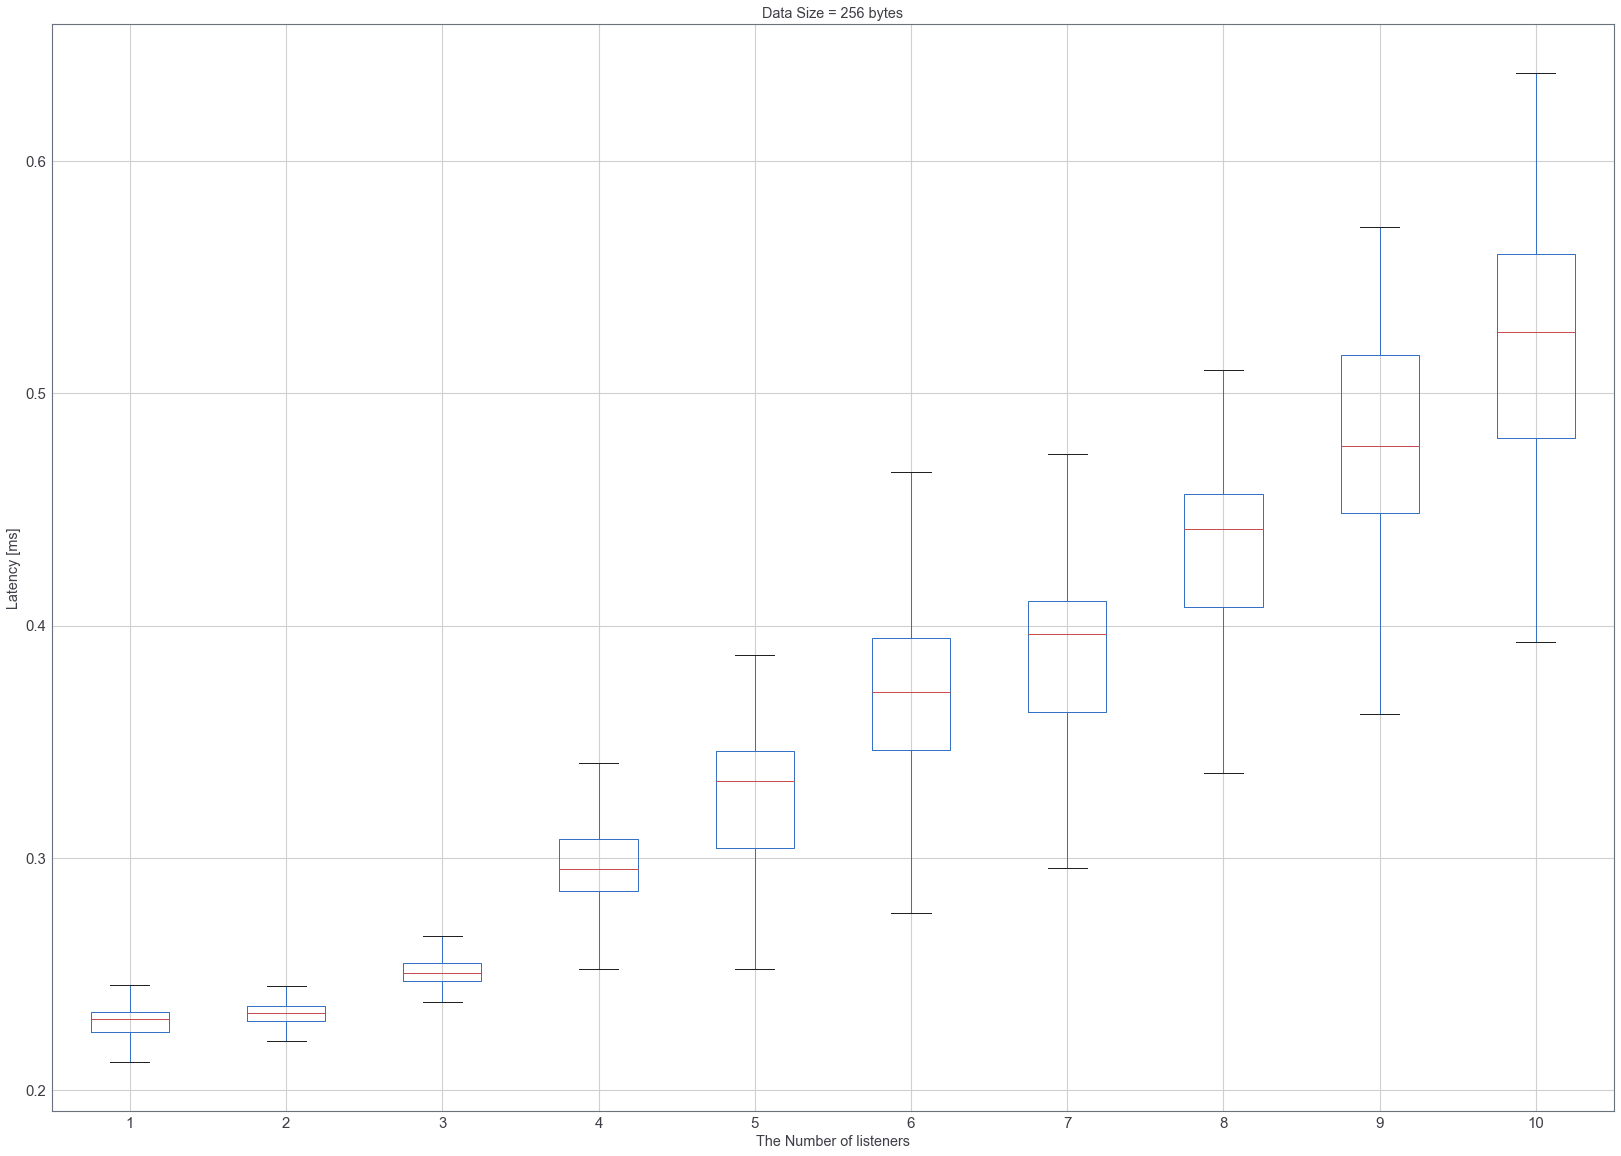

In [5]:
plt.figure(num=1, figsize=(28,20))
boxplot = df_256.boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("The Number of listeners")
boxplot.set_title("Data Size = 256 bytes")
plt.savefig("./q7/figure/boxplot_256.pdf", dpi=1200)

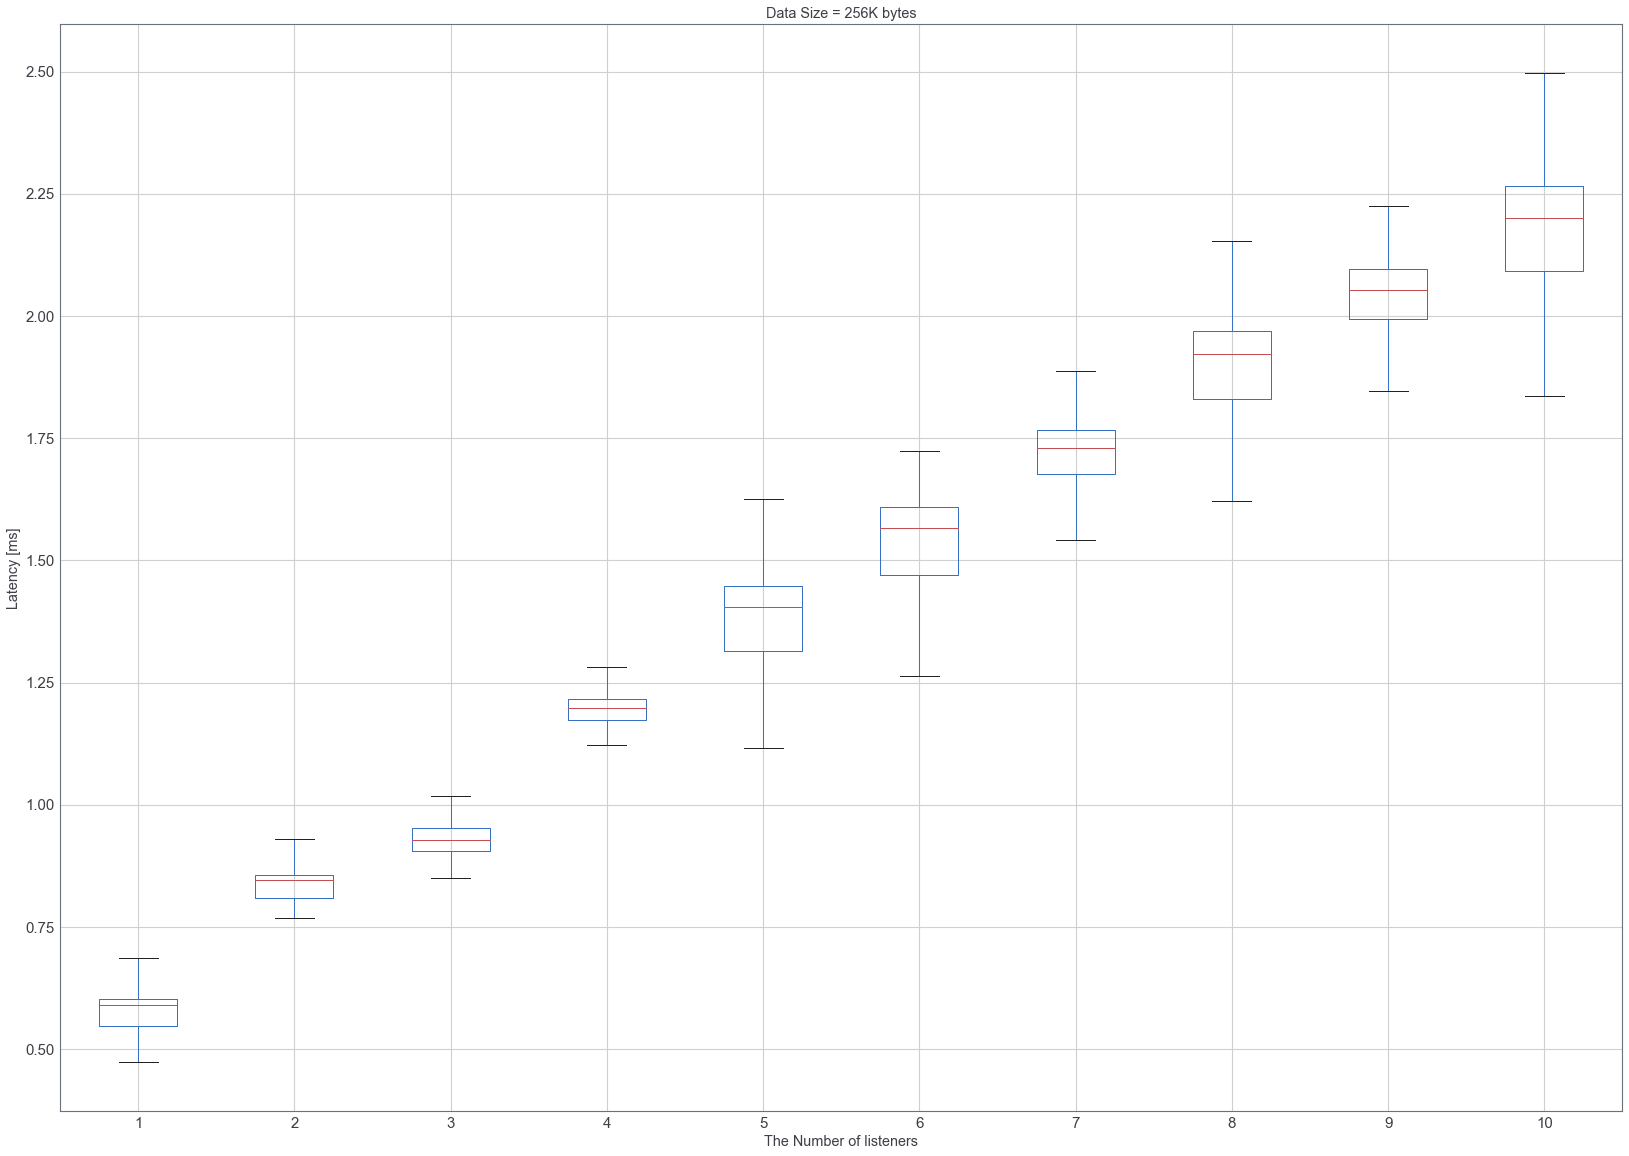

In [6]:
plt.figure(num=2, figsize=(28,20))
boxplot = df_256K.boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("The Number of listeners")
boxplot.set_title("Data Size = 256K bytes")
plt.savefig("./q7/figure/boxplot_256K.pdf", dpi=1200)

# Histogram

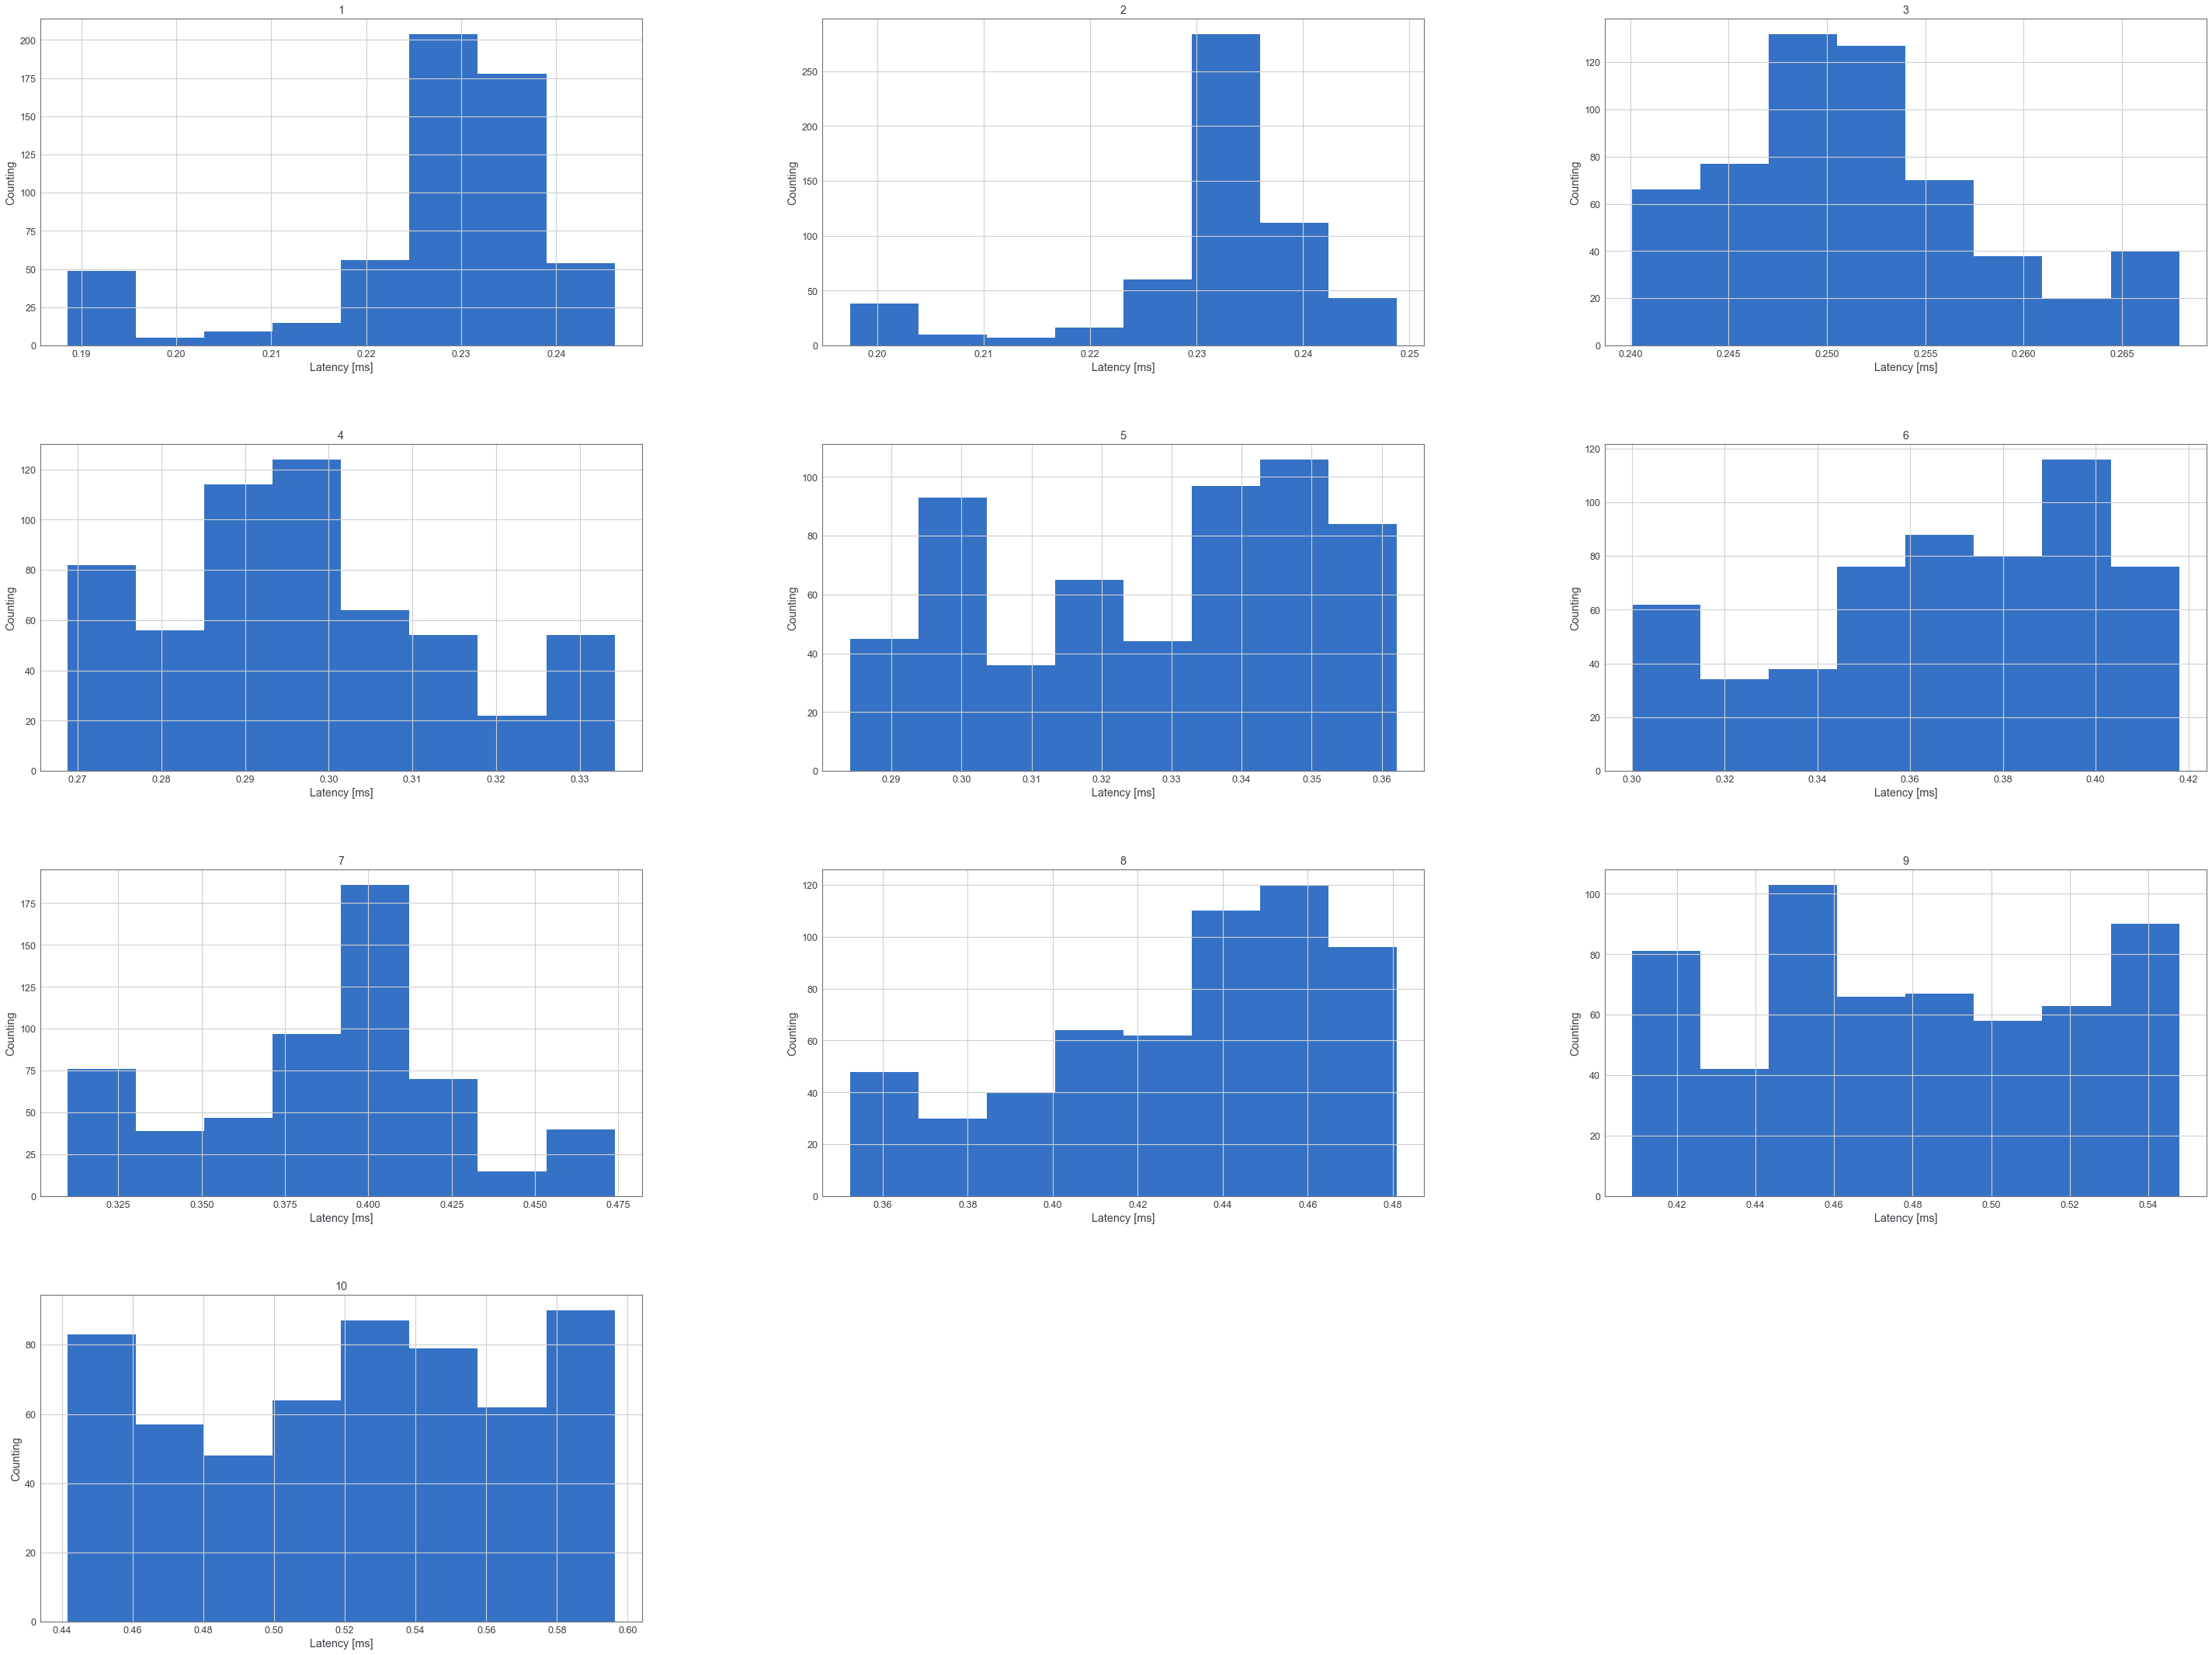

In [7]:
temp = df_256.apply(cap, quantile=[0.05,0.95])
hisFigAll = temp.hist(bins=8, figsize=(50,38))
for axis in hisFigAll.flatten():
    axis.set_xlabel("Latency [ms]")
    axis.set_ylabel("Counting")
plt.savefig("./q7/figure/his_256.pdf", dpi=1200)

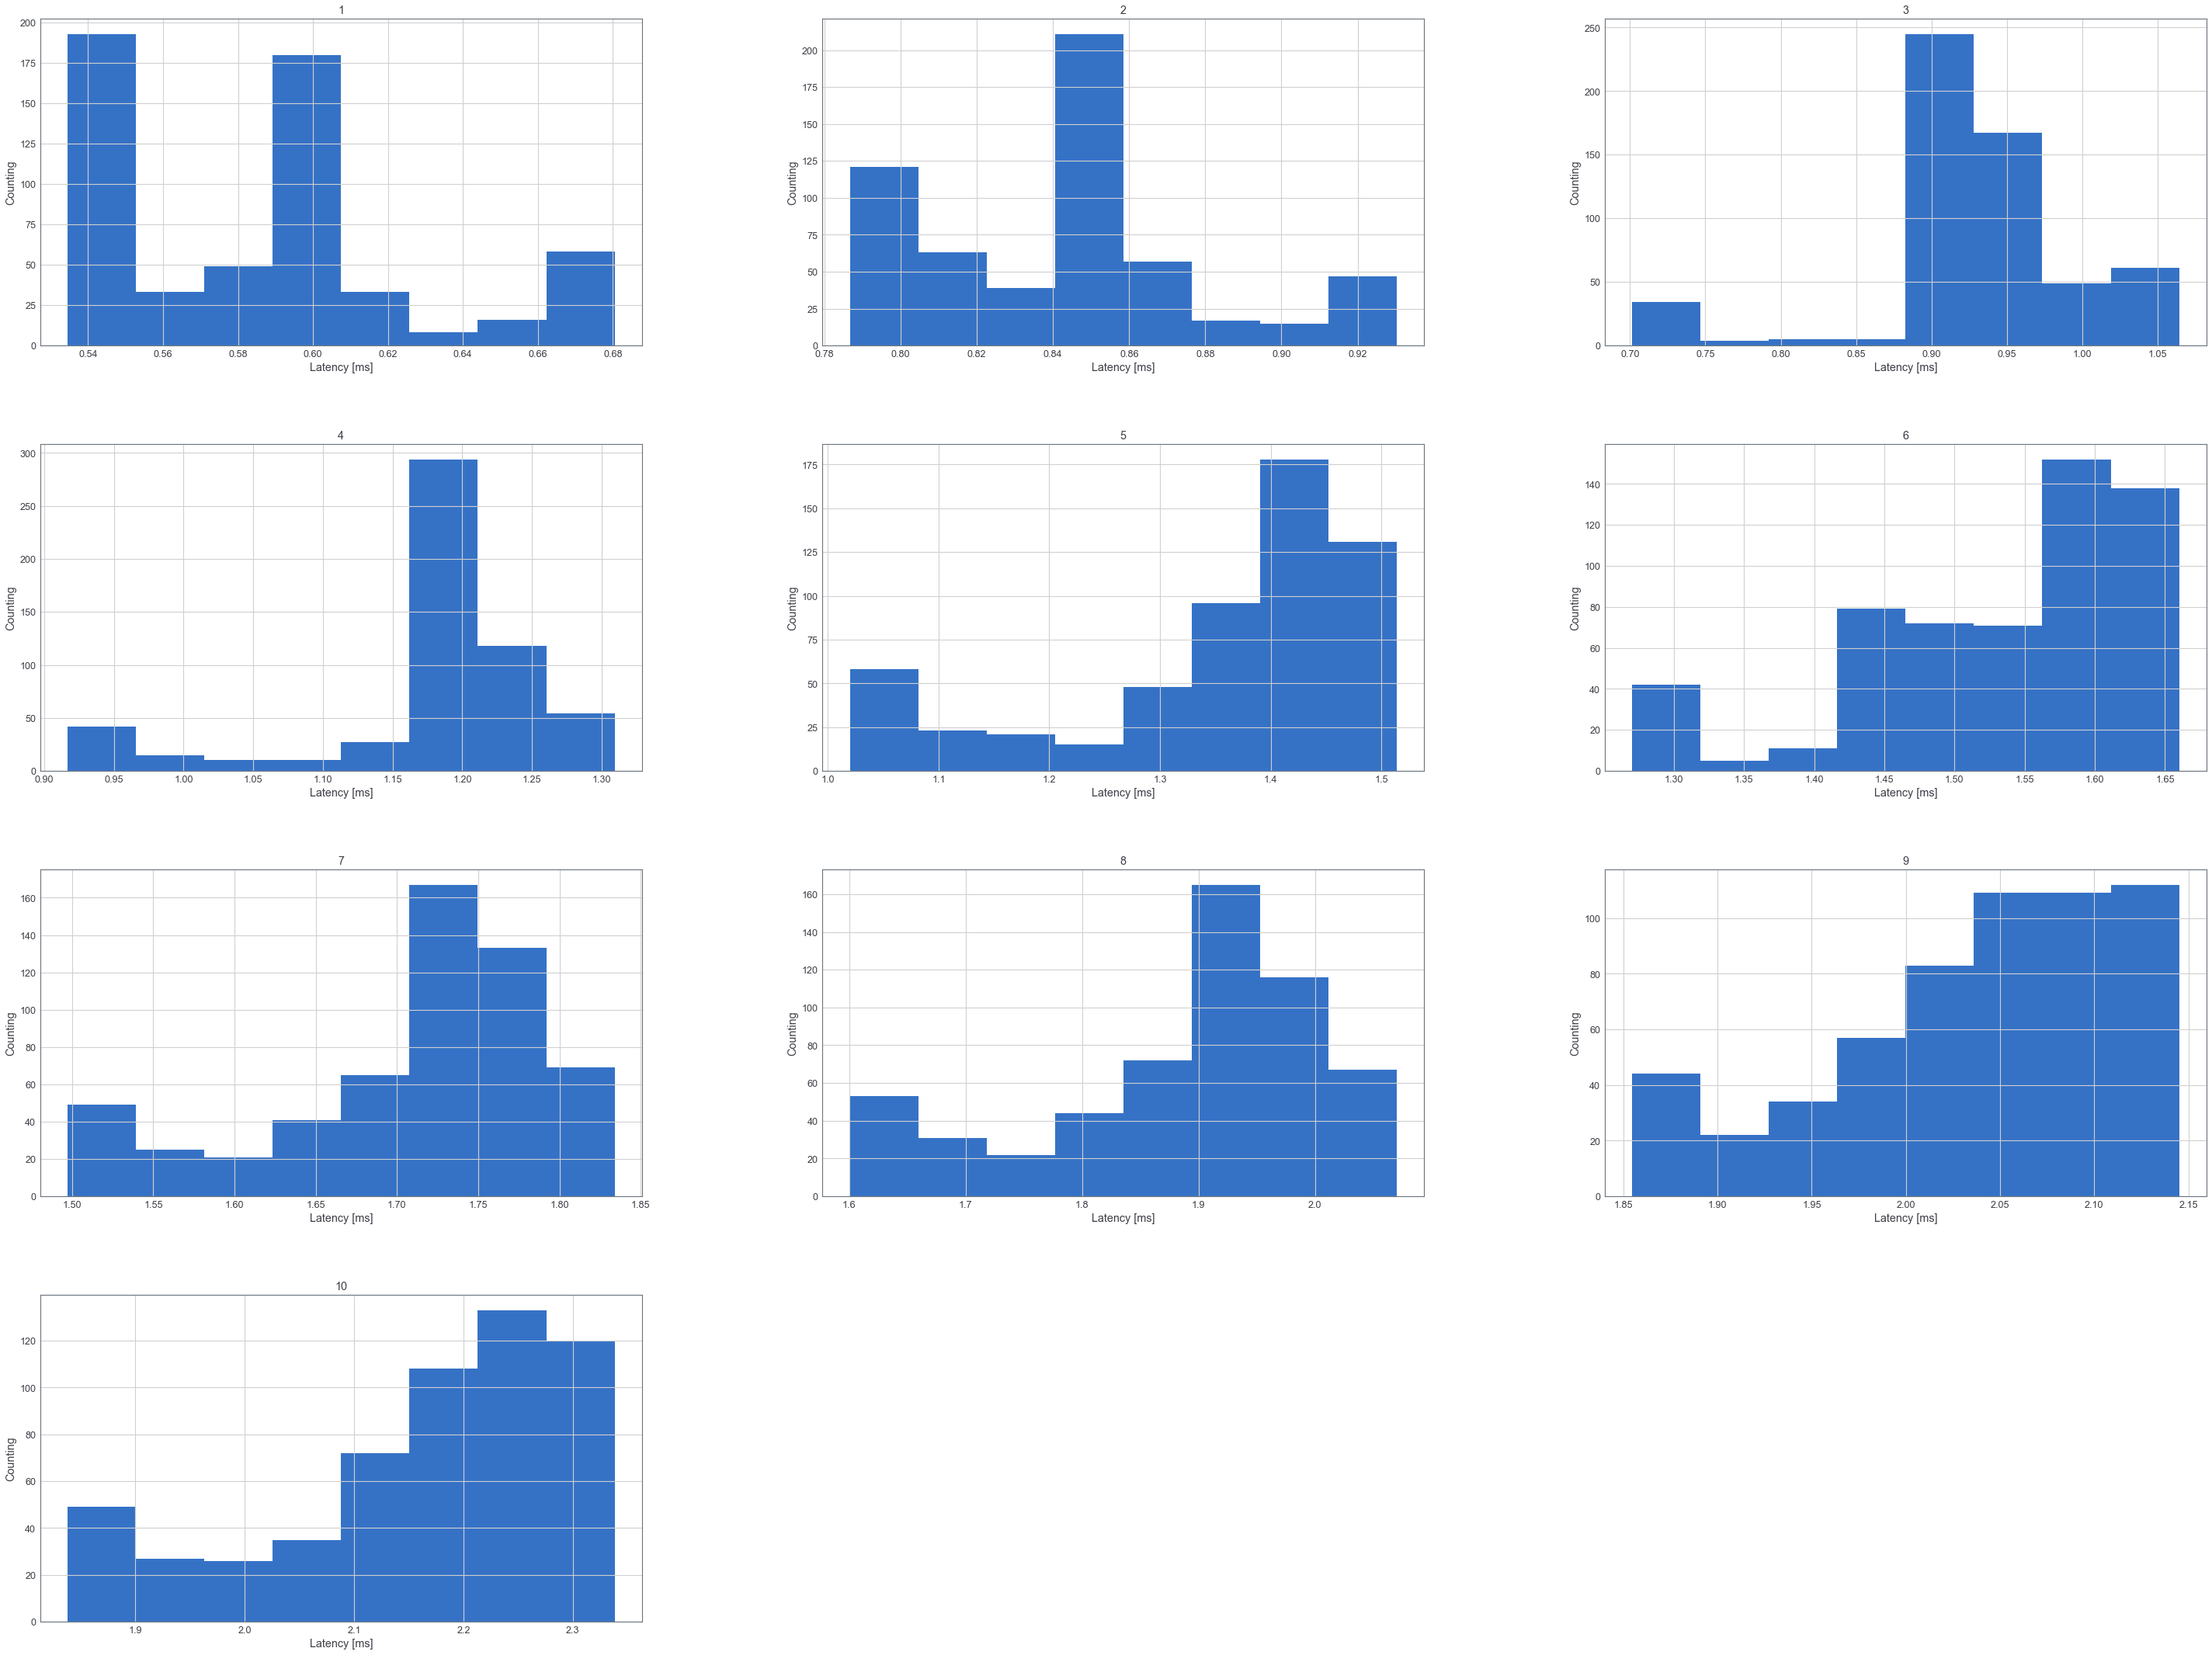

In [8]:
temp = df_256K.apply(cap, quantile=[0.05,0.95])
hisFigAll = temp.hist(bins=8, figsize=(50,38))
for axis in hisFigAll.flatten():
    axis.set_xlabel("Latency [ms]")
    axis.set_ylabel("Counting")
plt.savefig("./q7/figure/his_256K.pdf", dpi=1200)

# ANOVA

In [9]:
anova = pd.DataFrame({
    "latency": np.hstack((data_256, data_256K)).flatten("F"),
    
    "Size": np.repeat(["256", "256K"], 10*570),
    
    "Num_Listeners": np.r_[np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570)]
})

In [10]:
model_summary = rp.summary_cont(anova.groupby(['Size', 'Num_Listeners']))['latency']
model_summary

N    Mean      SD      SE  95% Conf.  Interval
Size Num_Listeners                                                  
256  1              570  0.2269  0.0165  0.0007     0.2255    0.2282
     2              570  0.2314  0.0132  0.0006     0.2303    0.2324
     3              570  0.2518  0.0131  0.0005     0.2507    0.2529
     4              570  0.2996  0.0602  0.0025     0.2946    0.3045
     5              570  0.3294  0.0649  0.0027     0.3240    0.3347
     6              570  0.3708  0.0723  0.0030     0.3648    0.3767
     7              570  0.3943  0.0845  0.0035     0.3874    0.4013
     8              570  0.4330  0.0699  0.0029     0.4273    0.4388
     9              570  0.4810  0.0767  0.0032     0.4747    0.4873
     X              570  0.5251  0.0840  0.0035     0.5182    0.5320
256K 1              570  0.5835  0.0555  0.0023     0.5789    0.5881
     2              570  0.8346  0.0708  0.0030     0.8288    0.8404
     3              570  0.9266  0.0904  0.0038     0.9192    0.9341
     4              570  1.1799  0.1163  0.0049     1.1704    1.1895
     5              570  1.3552  0.1786  0.0075     1.3405    1.3699
     6              570  1.5325  0.1311  0.0055     1.5217    1.5433
     7              570  1.7051  0.1071  0.0045     1.6963    1.7139
     8              570  1.9404  0.7063  0.0296     1.8823    1.9985
     9              570  2.0588  0.4889  0.0205     2.0186    2.0990
     X              570  2.1633  0.1669  0.0070     2.1495    2.1770

In [11]:
model_summary.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n     &   &    N &    Mean &      SD &      SE &  95\\% Conf. &  Interval \\\\\nSize & Num\\_Listeners &      &         &         &         &            &           \\\\\n\\midrule\n256 & 1 &  570 &  0.2269 &  0.0165 &  0.0007 &     0.2255 &    0.2282 \\\\\n     & 2 &  570 &  0.2314 &  0.0132 &  0.0006 &     0.2303 &    0.2324 \\\\\n     & 3 &  570 &  0.2518 &  0.0131 &  0.0005 &     0.2507 &    0.2529 \\\\\n     & 4 &  570 &  0.2996 &  0.0602 &  0.0025 &     0.2946 &    0.3045 \\\\\n     & 5 &  570 &  0.3294 &  0.0649 &  0.0027 &     0.3240 &    0.3347 \\\\\n     & 6 &  570 &  0.3708 &  0.0723 &  0.0030 &     0.3648 &    0.3767 \\\\\n     & 7 &  570 &  0.3943 &  0.0845 &  0.0035 &     0.3874 &    0.4013 \\\\\n     & 8 &  570 &  0.4330 &  0.0699 &  0.0029 &     0.4273 &    0.4388 \\\\\n     & 9 &  570 &  0.4810 &  0.0767 &  0.0032 &     0.4747 &    0.4873 \\\\\n     & X &  570 &  0.5251 &  0.0840 &  0.0035 &     0.5182 &    0.5320 \\\\\n256K & 1 &

In [12]:
model = ols('latency ~ C(Num_Listeners) + C(Size) + C(Num_Listeners)*C(Size)', anova).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 19, 11380) =  5723.713, p =  0.0000


In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                latency   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     5724.
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:13:20   Log-Likelihood:                 1544.0
No. Observations:               11400   AIC:                            -3048.
Df Residuals:                   11380   BIC:                            -2901.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.2269      0.009     25.610      0.000       0.210       0.244
C(Num_Listeners)[T.2]                     0.0045      0.013      0.357      0.721      -0.020       0.029
C(Num_Listeners)[T.3]                     0.0249      0.013      1.988      0.047       0.000       0.049
C(Num_Listeners)[T.4]                     0.0727      0.013      5.801      0.000       0.048       0.097
C(Num_Listeners)[T.5]                     0.1025      0.013      8.181      0.000       0.078       0.127
C(Num_Listeners)[T.6]                     0.1439      0.013     11.487      0.000       0.119       0.168
C(Num_Listeners)[T.7]                     0.1675      0.013     13.367      0.000       0.143       0.192
C(Num_Listeners)[T.8]                     0.2062      0.013     16.455      0.000       0.182       0.231
C(Num_Listeners)[T.9]                     0.2541      0.013     20.282      0.000       0.230       0.279
C(Num_Listeners)[T.X]                     0.2982      0.013     23.801      0.000       0.274       0.323
C(Size)[T.256K]                           0.3566      0.013     28.465      0.000       0.332       0.381
C(Num_Listeners)[T.2]:C(Size)[T.256K]     0.2466      0.018     13.919      0.000       0.212       0.281
C(Num_Listeners)[T.3]:C(Size)[T.256K]     0.3182      0.018     17.960      0.000       0.283       0.353
C(Num_Listeners)[T.4]:C(Size)[T.256K]     0.5238      0.018     29.561      0.000       0.489       0.558
C(Num_Listeners)[T.5]:C(Size)[T.256K]     0.6692      0.018     37.771      0.000       0.635       0.704
C(Num_Listeners)[T.6]:C(Size)[T.256K]     0.8051      0.018     45.438      0.000       0.770       0.840
C(Num_Listeners)[T.7]:C(Size)[T.256K]     0.9541      0.018     53.851      0.000       0.919       0.989
C(Num_Listeners)[T.8]:C(Size)[T.256K]     1.1507      0.018     64.947      0.000       1.116       1.185
C(Num_Listeners)[T.9]:C(Size)[T.256K]     1.2212      0.018     68.923      0.000       1.186       1.256
C(Num_Listeners)[T.X]:C(Size)[T.256K]     1.2816      0.018     72.331      0.000       1.247       1.316
==============================================================================
Omnibus:                    32017.033   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1406882530.004
Skew:                          36.688   Prob(JB):                         0.00
Kurtosis:                    1722.440   Cond. No.                         28.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Num_Listeners),1078.163487,9.0,2677.911220,0.0
C(Size),3285.443084,1.0,73442.594806,0.0
C(Num_Listeners):C(Size),501.332241,9.0,1245.194489,0.0
Residual,509.082534,11380.0,NaN,NaN


In [15]:
res.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &       sum\\_sq &       df &             F &  PR(>F) \\\\\n\\midrule\nC(Num\\_Listeners)         &  1078.163487 &      9.0 &   2677.911220 &     0.0 \\\\\nC(Size)                  &  3285.443084 &      1.0 &  73442.594806 &     0.0 \\\\\nC(Num\\_Listeners):C(Size) &   501.332241 &      9.0 &   1245.194489 &     0.0 \\\\\nResidual                 &   509.082534 &  11380.0 &           NaN &     NaN \\\\\n\\bottomrule\n\\end{tabular}\n'